In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [197]:
# read data from file
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [0]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [0]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [0]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [201]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [0]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [0]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [204]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [0]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [206]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [207]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Resolution', 'Sim1', 'Capacity', 'Pixel Density',
       'Num_cores', 'os_name', 'Weight', 'Height',
       'Screen to Body Ratio (calculated)', 'RAM', 'Brand', 'Screen Size',
       'Internal Memory', 'Processor_frequency', 'SIM Slot(s)', 'SIM 2'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Resolution', 'Capacity', 'Pixel Density', 'Weight',
       'Height', 'Screen to Body Ratio (calculated)', 'RAM', 'Screen Size',
       'Internal Memory', 'Processor_frequency', 'Sim1_2G', 'Sim1_3G',
       'Sim1_4G', 'Num_cores_312', 'Num_cores_Deca', 'Num_cores_Dual',
       'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad',
       'Num_cores_Tru-Octa', 'os_name_Android', 'os_name_Blackberry',
       'os_name_KAI', 'os_name_Nokia', 'os_name_Other', 'os_name_Tizen',
       'os_name_iOS', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus',
       'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad',
       'Brand_Do', 'Brand_Gionee', 

In [0]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [209]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [210]:
train_new.head()

,PhoneId,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,...,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Rating
0,0,20,4000,403,182,157.9,80.68,4,6.26,64,...,0,0,0,1,0,0,0,1,0,4.5
1,1,8,4230,271,168,156.2,80.85,3,6.20,32,...,0,0,0,1,0,0,0,1,0,4.5
2,2,25,3500,409,168,157.0,83.68,3,6.30,32,...,0,0,0,1,0,0,0,1,0,4.4
3,4,24,3300,411,169,159.8,74.78,4,6.00,64,...,0,0,1,0,0,0,0,1,0,4.3
4,5,16,3750,396,175,160.4,84.23,4,6.50,64,...,0,0,0,1,0,0,0,1,0,4.4


In [211]:
test_new.head()

,PhoneId,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,...,Brand_Yu,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other
0,3,5,4230,271,168,156.2,80.85,2,6.20,16,...,0,0,0,0,1,0,0,0,1,0
1,11,12,5000,402,205,156.0,81.60,4,6.20,64,...,0,0,0,0,1,0,0,0,1,0
2,13,25,3500,409,169,156.7,83.84,6,6.30,64,...,0,0,0,0,1,0,0,0,1,0
3,16,16,3500,409,169,156.7,83.84,4,6.30,64,...,0,0,0,0,1,0,0,0,1,0
4,19,20,4000,403,181,158.6,77.43,4,5.99,64,...,0,0,0,0,1,0,0,0,1,0


In [212]:
train_new.shape , test_new.shape

((341, 88), (119, 87))

In [213]:
X_train_new = train_new.drop(['PhoneId','Rating'], axis=1)
Y_train_new = train_new['Rating']
X_train_new.head()
Y_train_new.head()

0    4.5
1    4.5
2    4.4
3    4.3
4    4.4
Name: Rating, dtype: float64

 Create X_train_new which will hold all columns except PhoneID and Rating using train_new
Create Y_train_new which will only hold the Rating column present in train_new, note that the dataframe maintains integrity of the PhoneID 
which is very essential

Create X_test_new which will hold all columns except PhoneID
There is no Y_test_new for obvious reasons as this is what you will be predicting 

In [0]:
X_test_new = test_new.drop(['PhoneId'],axis=1)

In [0]:
Y_train_binarised = train_new['Rating'].map(lambda x: 1 if x>= 4 else 0)
#pd.DataFrame(Y_train_binarised).head()

In [216]:
X_train_new.describe()

,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,Processor_frequency,...,Brand_Yu,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,9.592375,3191.307918,344.211144,161.343109,149.946394,72.353343,11.120235,5.462317,46.369501,1.792551,...,0.011730,0.002933,0.002933,0.759531,0.152493,0.085044,0.211144,0.020528,0.683284,0.085044
std,5.953827,932.533527,88.161129,22.305556,9.192305,9.357839,61.320855,0.742529,46.435453,0.451598,...,0.107827,0.054153,0.054153,0.427996,0.360026,0.279357,0.408720,0.142006,0.465879,0.279357
min,2.000000,1020.000000,143.000000,58.000000,115.600000,23.600000,1.000000,2.400000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2900.000000,282.000000,150.000000,146.200000,68.800000,2.000000,5.200000,16.000000,1.400000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,3055.000000,326.000000,161.000000,151.300000,72.500000,3.000000,5.500000,32.000000,1.800000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,13.000000,3750.000000,403.000000,172.000000,156.200000,77.480000,4.000000,6.000000,64.000000,2.200000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,25.000000,13000.000000,576.000000,330.000000,174.100000,87.660000,512.000000,6.590000,512.000000,2.800000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [217]:
X_test_new.describe()

,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,Processor_frequency,...,Brand_Yu,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,...,119.0,119.0,119.0,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,9.294118,3233.764706,334.731092,164.000000,150.277679,71.955630,11.983193,5.463445,48.336134,1.768403,...,0.0,0.0,0.0,0.789916,0.184874,0.025210,0.235294,0.025210,0.714286,0.025210
std,5.618301,772.097887,102.821278,16.698726,8.516004,10.349265,65.670335,0.759304,49.842001,0.471133,...,0.0,0.0,0.0,0.409091,0.389837,0.157426,0.425976,0.157426,0.453664,0.157426
min,2.000000,1020.000000,114.000000,105.000000,111.500000,18.890000,1.000000,1.800000,0.000000,1.100000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3000.000000,269.500000,154.000000,146.550000,68.835000,2.000000,5.100000,16.000000,1.400000,...,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,3050.000000,294.000000,164.000000,151.700000,72.120000,3.000000,5.500000,32.000000,1.770000,...,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,13.000000,3725.000000,402.000000,173.500000,155.900000,77.220000,4.000000,5.995000,64.000000,2.000000,...,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,25.000000,5000.000000,745.000000,218.000000,173.800000,85.430000,512.000000,6.500000,256.000000,2.960000,...,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [218]:
X_train_corr = X_train_new.iloc[:,[0,1,2,3,4,5,6,7,8,9]]
print(X_train_corr.shape)
X_train_corr.head()

(341, 10)


,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,Processor_frequency
0,20,4000,403,182,157.9,80.68,4,6.26,64,1.8
1,8,4230,271,168,156.2,80.85,3,6.20,32,1.8
2,25,3500,409,168,157.0,83.68,3,6.30,32,2.1
3,24,3300,411,169,159.8,74.78,4,6.00,64,2.2
4,16,3750,396,175,160.4,84.23,4,6.50,64,2.2


In [219]:
correlations = X_train_corr.corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0']!= correlations['level_1']]
correlations.tail(10)

,level_0,level_1,0
80,Height,Weight,0.642595
81,Weight,Height,0.642595
82,Capacity,Weight,0.687891
83,Weight,Capacity,0.687891
84,Screen to Body Ratio (calculated),Height,0.744119
85,Height,Screen to Body Ratio (calculated),0.744119
86,Height,Screen Size,0.861143
87,Screen Size,Height,0.861143
88,Screen Size,Screen to Body Ratio (calculated),0.930492
89,Screen to Body Ratio (calculated),Screen Size,0.930492


VIsual Interpretation of Corrleation

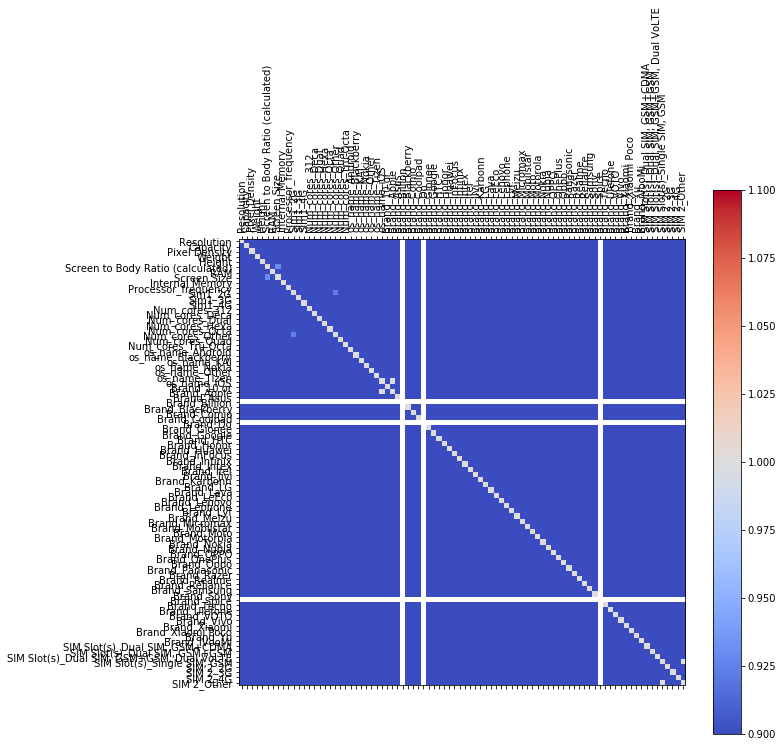

In [220]:
corr= X_train_new.corr()
fig = plt.figure()
fig.set_size_inches(10,10)
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm',vmin=1,vmax=1)
fig.colorbar(cax)
ticks= np.arange(0,len(X_train_new.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X_train_new.columns)
ax.set_yticklabels(X_train_new.columns)
plt.show()

In [221]:
X_train_rating_binary = pd.concat([X_train_new,Y_train_binarised],axis=1)
X_train_rating_discrete = pd.concat([X_train_new, Y_train_new])
X_train_rating_binary.head()

,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,Processor_frequency,...,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Rating
0,20,4000,403,182,157.9,80.68,4,6.26,64,1.8,...,0,0,0,1,0,0,0,1,0,1
1,8,4230,271,168,156.2,80.85,3,6.20,32,1.8,...,0,0,0,1,0,0,0,1,0,1
2,25,3500,409,168,157.0,83.68,3,6.30,32,2.1,...,0,0,0,1,0,0,0,1,0,1
3,24,3300,411,169,159.8,74.78,4,6.00,64,2.2,...,0,0,1,0,0,0,0,1,0,1
4,16,3750,396,175,160.4,84.23,4,6.50,64,2.2,...,0,0,0,1,0,0,0,1,0,1


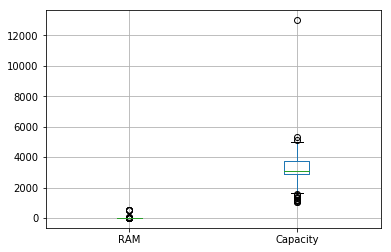

In [222]:
X_train_rating_binary.boxplot(column=['RAM','Capacity'])

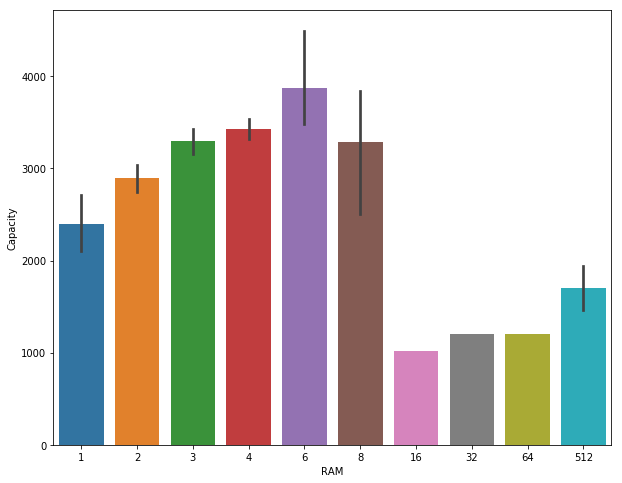

In [223]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.barplot(x='RAM',y='Capacity',data=X_train_rating_binary)

In [0]:
#!pip install seaborn --upgrade

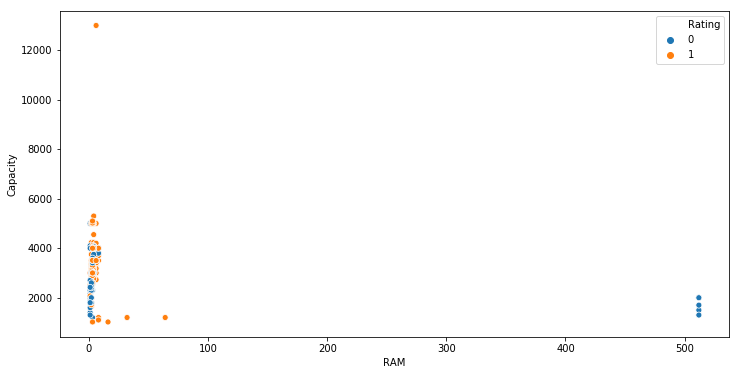

In [225]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='RAM',y='Capacity',hue='Rating', data=X_train_rating_binary)

box plot screen size vs pixel density

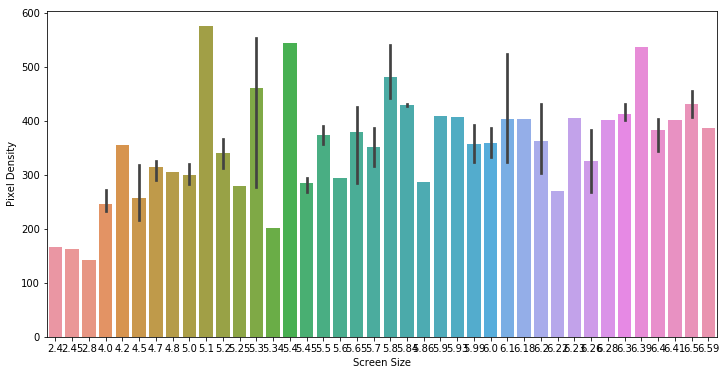

In [226]:
plt.figure(figsize=(12,6))
sns.barplot(x='Screen Size',y='Pixel Density',data=X_train_rating_binary)

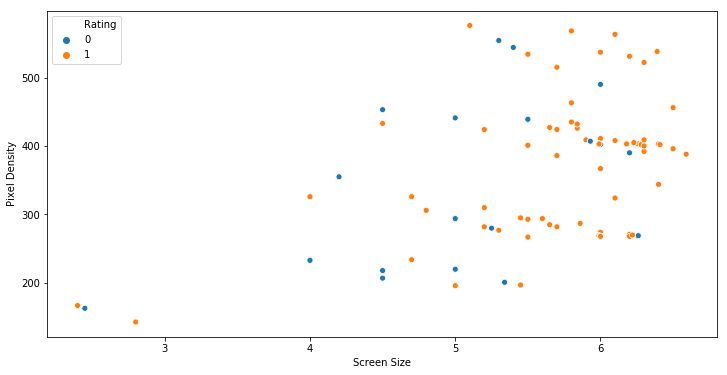

In [227]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Screen Size',y='Pixel Density', hue='Rating',data=X_train_rating_binary)

Resoluton vs Pixel Density

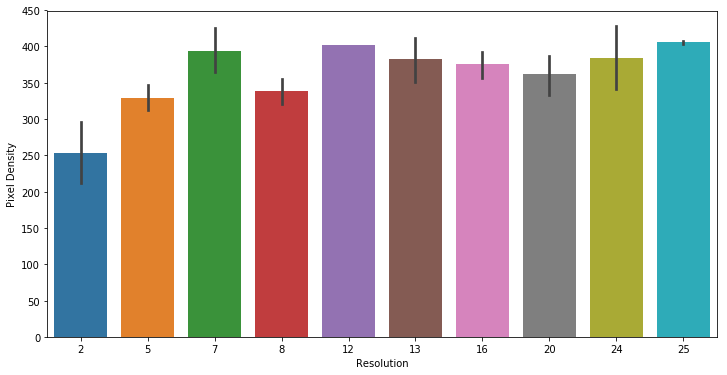

In [228]:
plt.figure(figsize=(12,6))
sns.barplot(x='Resolution',y='Pixel Density',data=X_train_rating_binary)

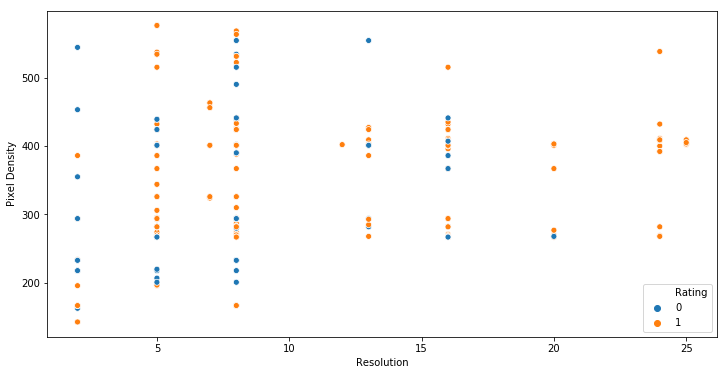

In [229]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Resolution',y='Pixel Density',hue='Rating', data=X_train_rating_binary)

Internal Memory Vs  Weight

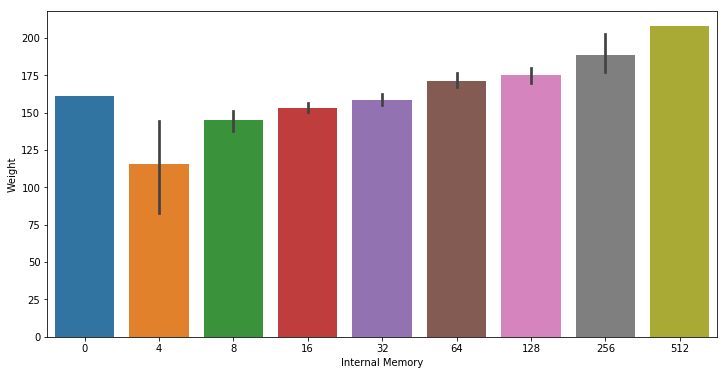

In [230]:
plt.figure(figsize=(12,6))
sns.barplot(x='Internal Memory', y='Weight',data=X_train_rating_binary)

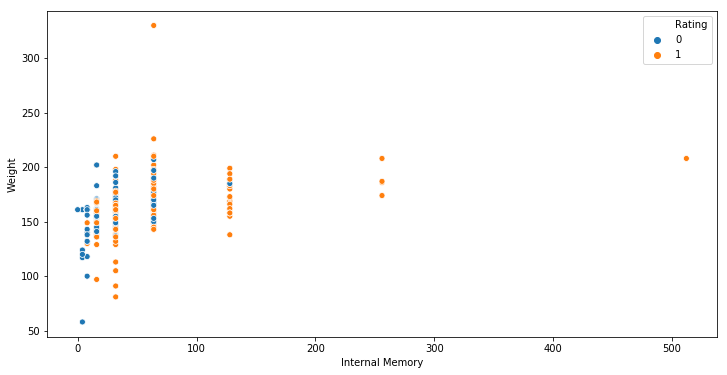

In [231]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Internal Memory',y='Weight',hue='Rating',data=X_train_rating_binary)

Phones high on Internal Memory are liked more than the ones having no internal memory


Capacity  Vs Weight

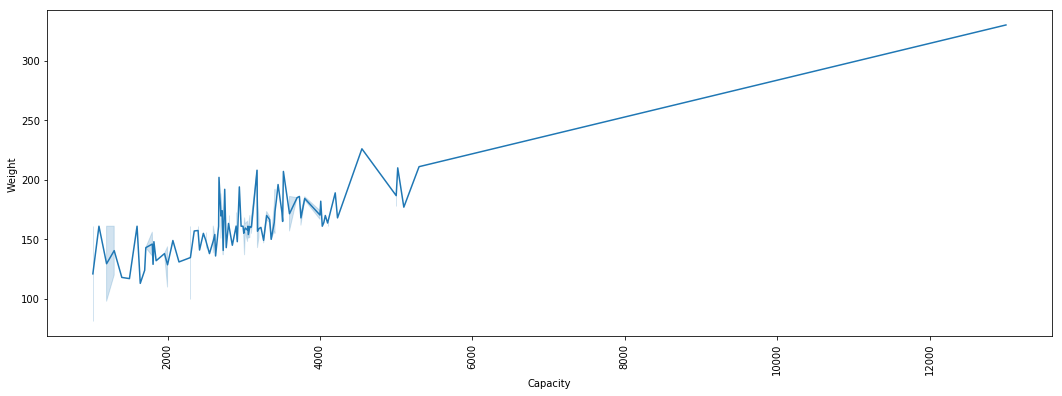

In [232]:
plt.figure(figsize=(18,6))
plt.xticks(rotation='vertical')
sns.lineplot(x='Capacity',y='Weight',data=X_train_rating_binary)

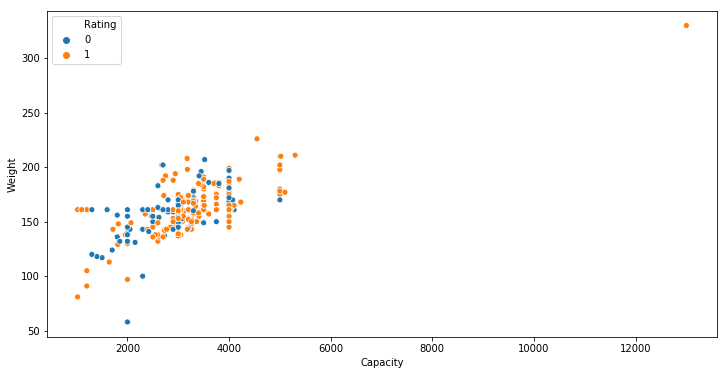

In [233]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Capacity',y='Weight',hue='Rating',data=X_train_rating_binary)

In [234]:
X_train_rating_binary.head()

,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,Processor_frequency,...,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Rating
0,20,4000,403,182,157.9,80.68,4,6.26,64,1.8,...,0,0,0,1,0,0,0,1,0,1
1,8,4230,271,168,156.2,80.85,3,6.20,32,1.8,...,0,0,0,1,0,0,0,1,0,1
2,25,3500,409,168,157.0,83.68,3,6.30,32,2.1,...,0,0,0,1,0,0,0,1,0,1
3,24,3300,411,169,159.8,74.78,4,6.00,64,2.2,...,0,0,1,0,0,0,0,1,0,1
4,16,3750,396,175,160.4,84.23,4,6.50,64,2.2,...,0,0,0,1,0,0,0,1,0,1


In [235]:
X_train_rating_binary.columns

Index(['Resolution', 'Capacity', 'Pixel Density', 'Weight', 'Height',
       'Screen to Body Ratio (calculated)', 'RAM', 'Screen Size',
       'Internal Memory', 'Processor_frequency', 'Sim1_2G', 'Sim1_3G',
       'Sim1_4G', 'Num_cores_312', 'Num_cores_Deca', 'Num_cores_Dual',
       'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad',
       'Num_cores_Tru-Octa', 'os_name_Android', 'os_name_Blackberry',
       'os_name_KAI', 'os_name_Nokia', 'os_name_Other', 'os_name_Tizen',
       'os_name_iOS', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus',
       'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad',
       'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor',
       'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex',
       'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava',
       'Brand_LeEco', 'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf',
       'Brand_Meizu', 'Brand_Micromax', 'Brand_Mobiistar', '

Screen to Body Ratio VS Capacity

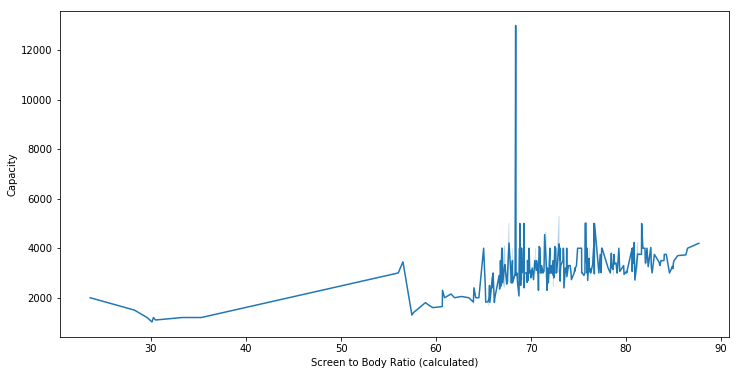

In [236]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Screen to Body Ratio (calculated)',y='Capacity',data=X_train_rating_binary)

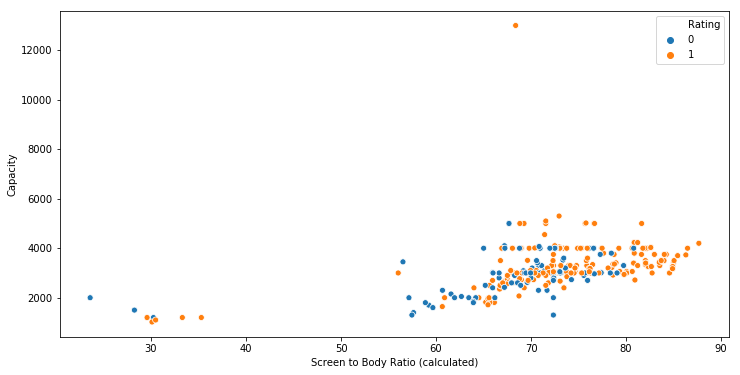

In [237]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Screen to Body Ratio (calculated)',y='Capacity',hue= 'Rating',data=X_train_rating_binary)

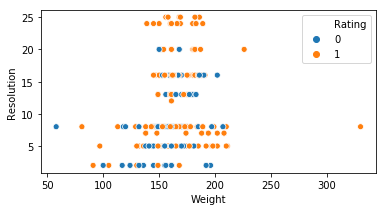

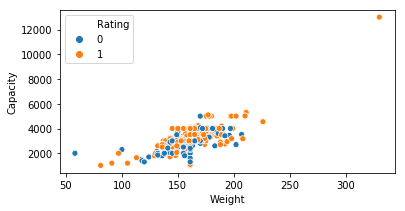

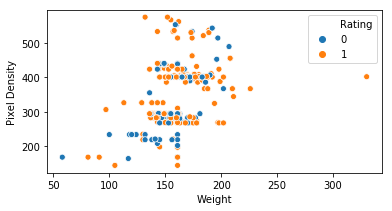

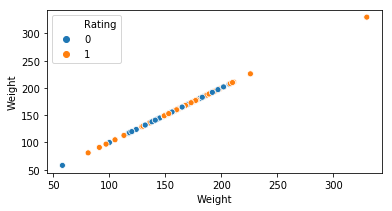

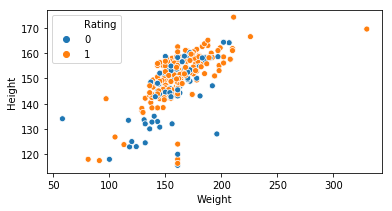

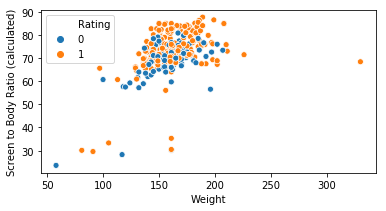

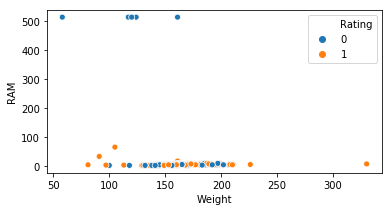

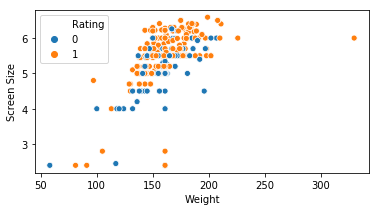

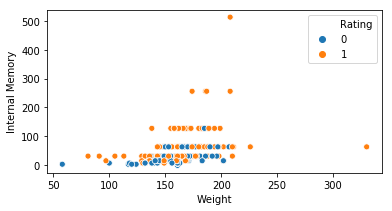

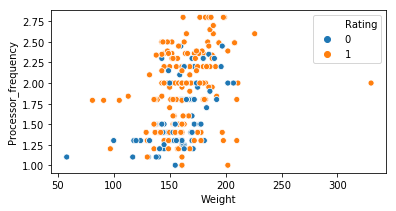

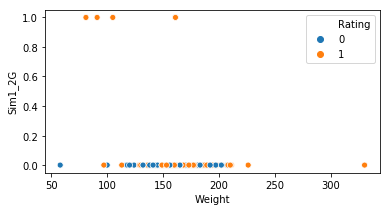

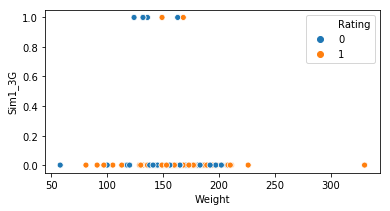

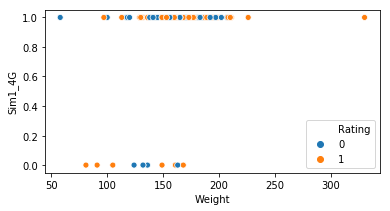

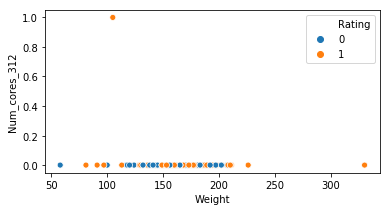

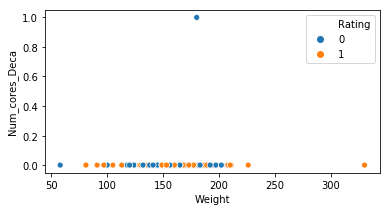

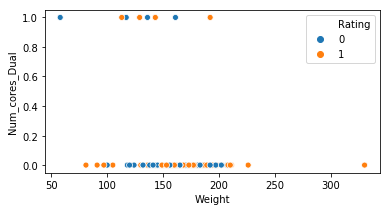

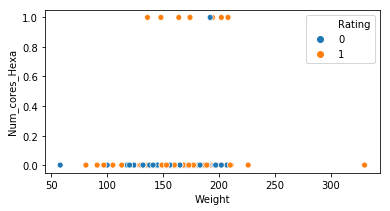

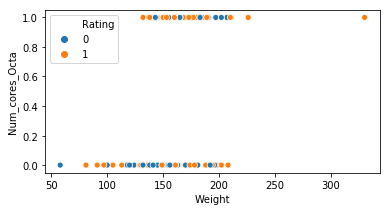

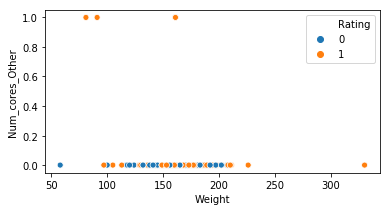

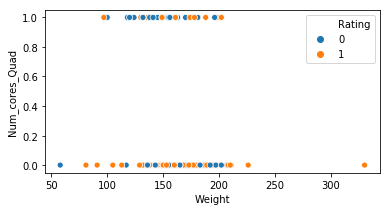

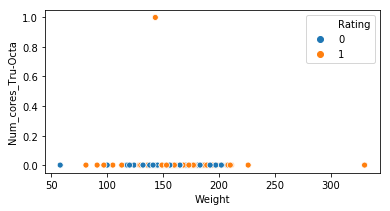

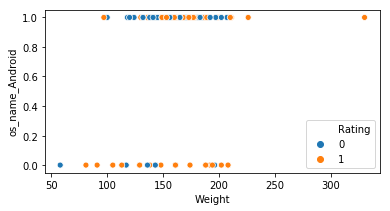

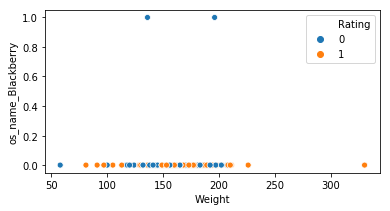

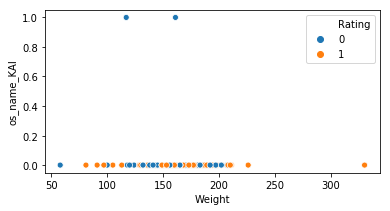

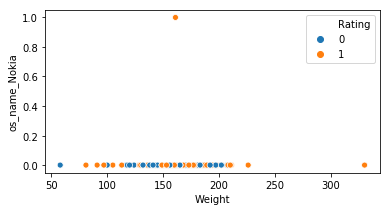

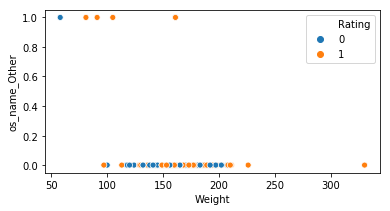

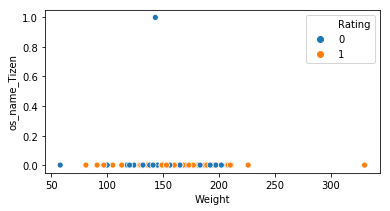

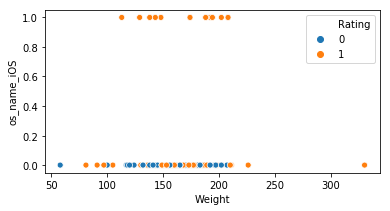

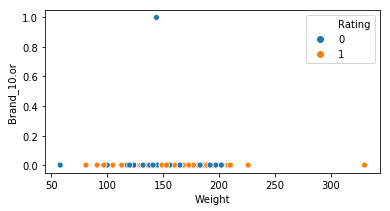

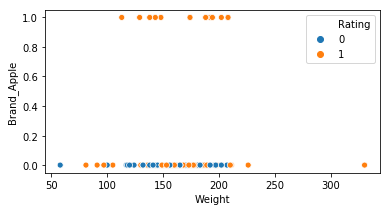

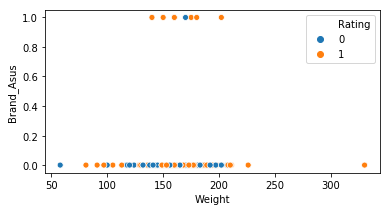

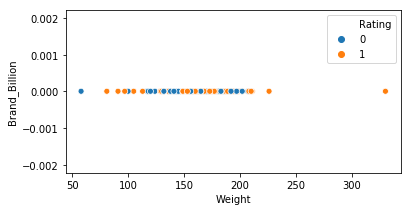

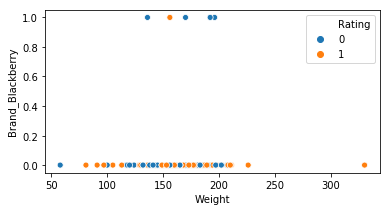

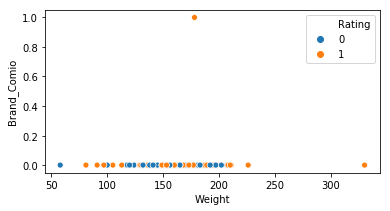

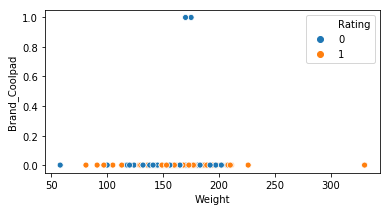

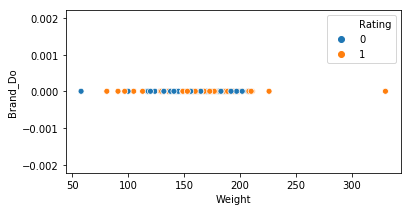

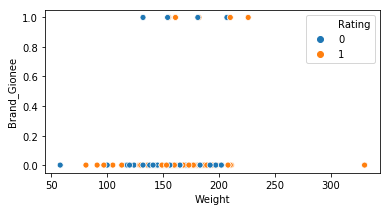

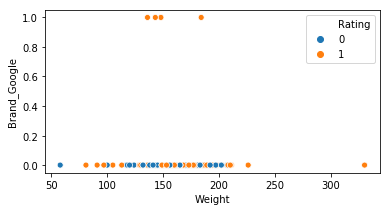

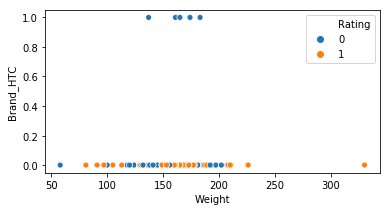

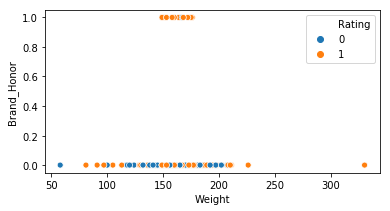

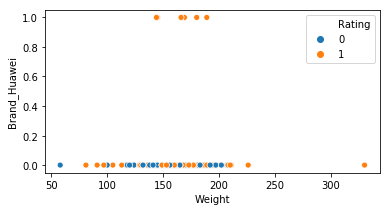

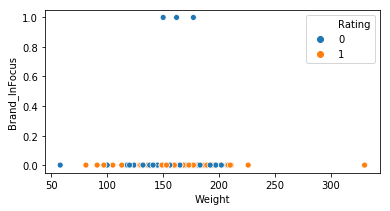

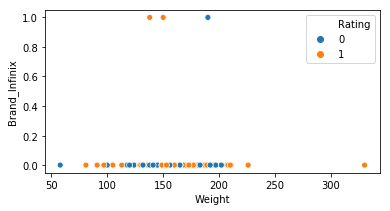

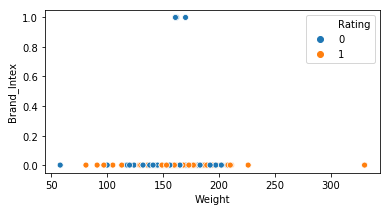

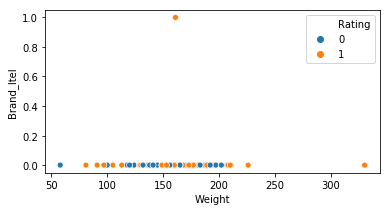

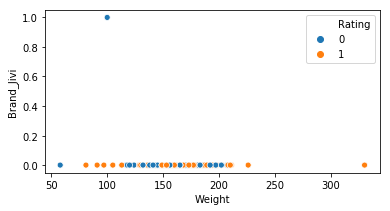

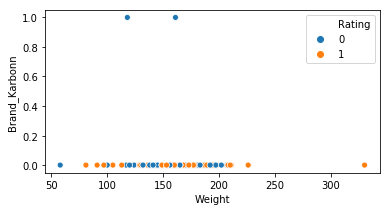

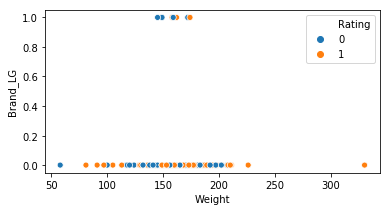

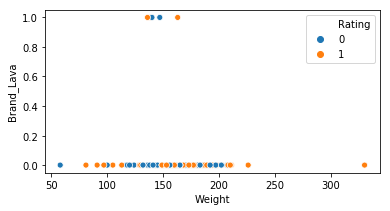

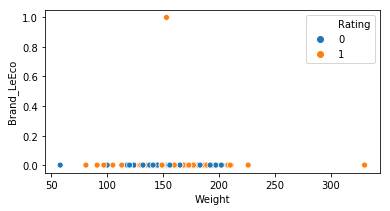

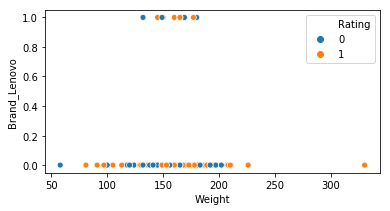

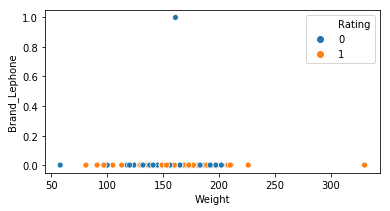

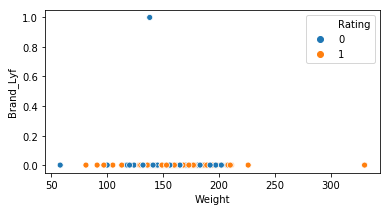

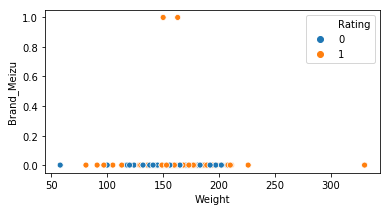

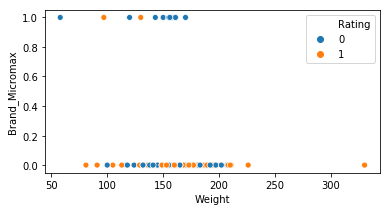

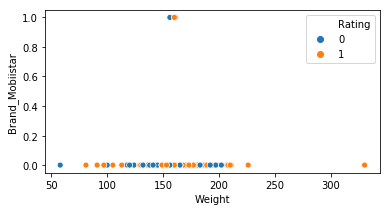

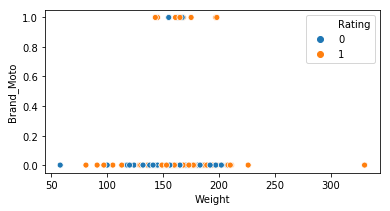

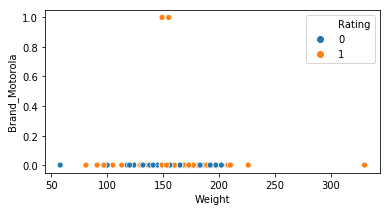

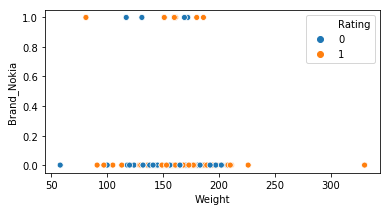

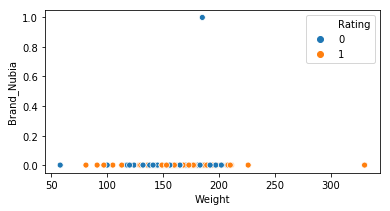

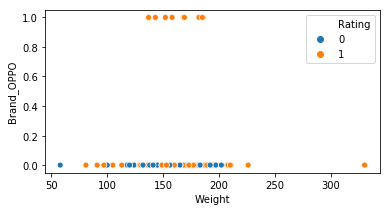

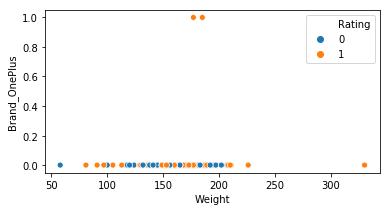

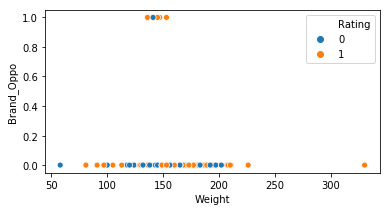

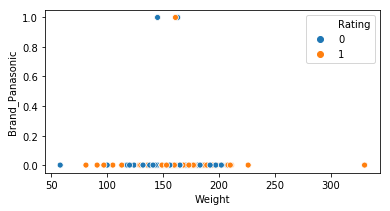

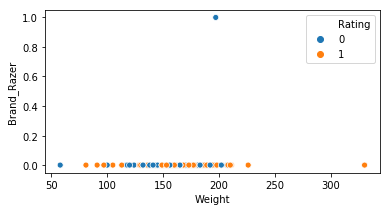

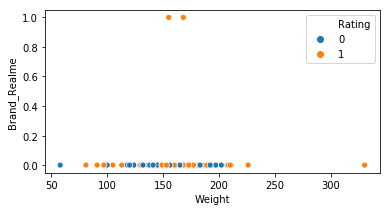

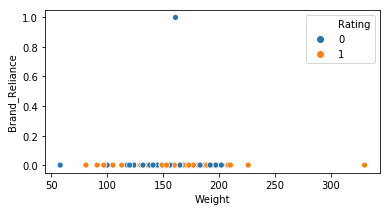

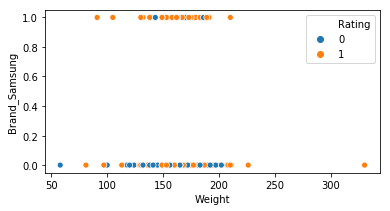

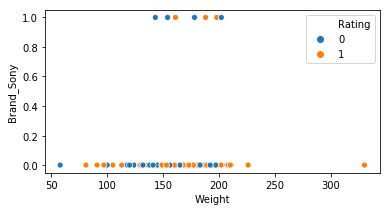

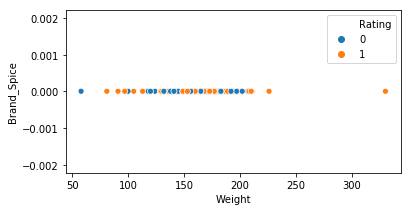

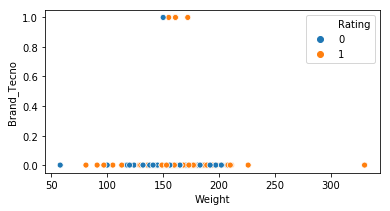

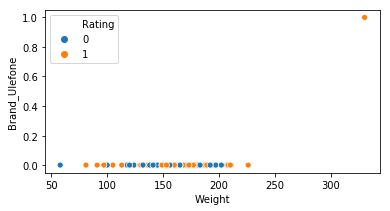

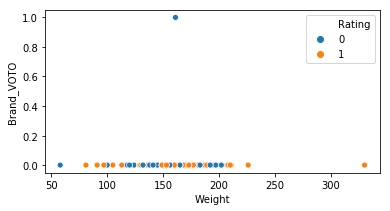

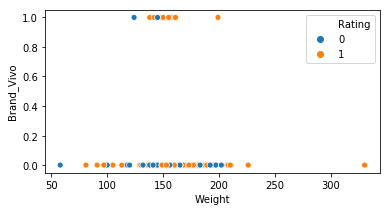

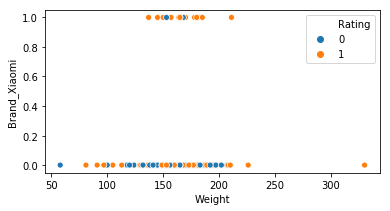

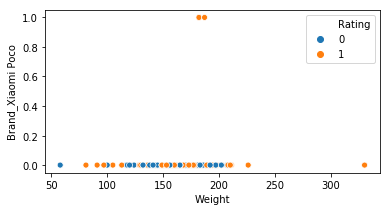

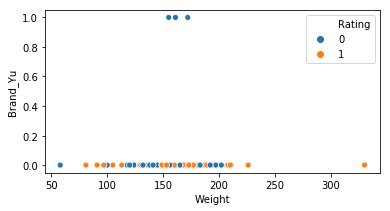

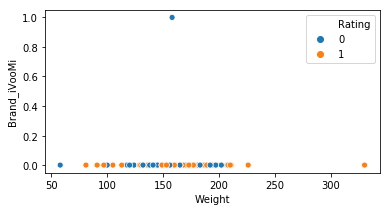

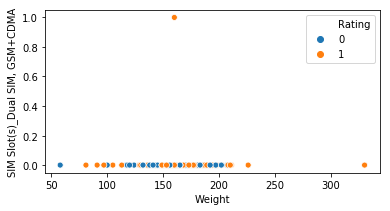

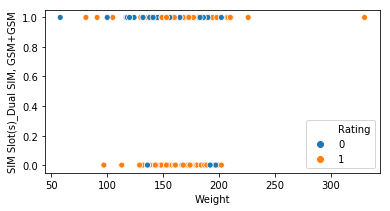

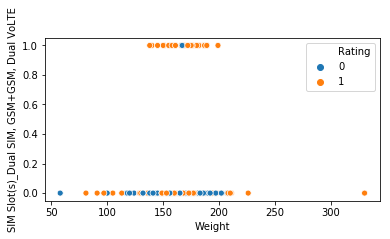

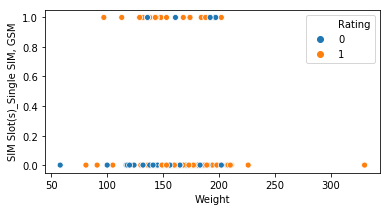

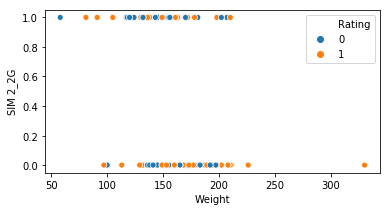

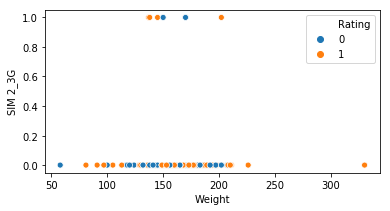

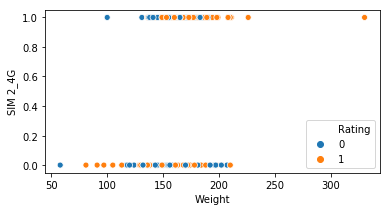

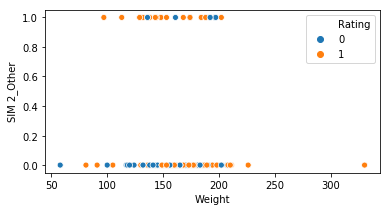

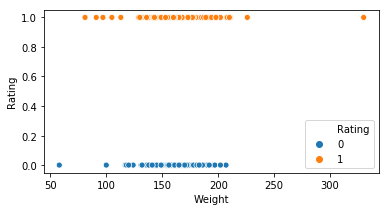

In [238]:
for i in range(X_train_rating_binary.shape[1]):
  #x= X_train_rating_binary.columns[1]
  y=X_train_rating_binary.columns[i]
  plt.figure(figsize=(6,3))
  sns.scatterplot(x='Weight',y=y,hue='Rating',data=X_train_rating_binary)

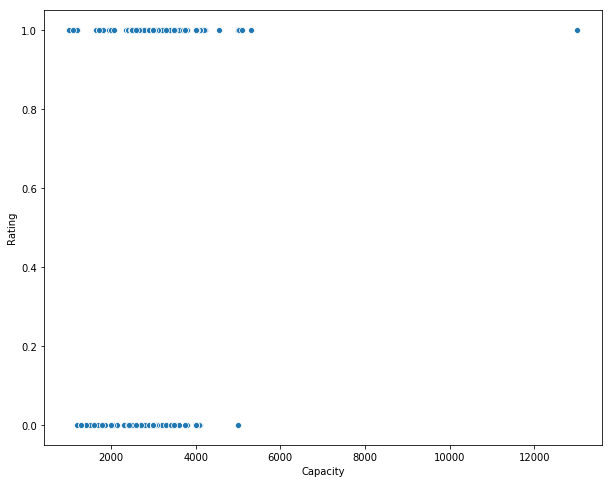

In [239]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Capacity',y='Rating',data=X_train_rating_binary)

In [240]:
X_train_rating_binary.head(5)

,Resolution,Capacity,Pixel Density,Weight,Height,Screen to Body Ratio (calculated),RAM,Screen Size,Internal Memory,Processor_frequency,...,Brand_iVooMi,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Rating
0,20,4000,403,182,157.9,80.68,4,6.26,64,1.8,...,0,0,0,1,0,0,0,1,0,1
1,8,4230,271,168,156.2,80.85,3,6.20,32,1.8,...,0,0,0,1,0,0,0,1,0,1
2,25,3500,409,168,157.0,83.68,3,6.30,32,2.1,...,0,0,0,1,0,0,0,1,0,1
3,24,3300,411,169,159.8,74.78,4,6.00,64,2.2,...,0,0,1,0,0,0,0,1,0,1
4,16,3750,396,175,160.4,84.23,4,6.50,64,2.2,...,0,0,0,1,0,0,0,1,0,1


X_train_binarised and X_test_binarised

writing the Perceptron Class

In [0]:
#Y_train_binarised = Y_train_binarised.values
#X_train_new= X_train_new.values
#X_test_new = X_test_new.values

In [0]:
class Perceptron:
  
  def __init__(self):
    self.w= None
    self.b= None
   
  def model(self,x):
    return 1 if (np.dot(self.w,x)>=self.b) else 0
  
  def predict(self,X):
    Y=[]
    for x in X:
      result = self.model(x)
      Y.append(result)
    return(np.array(Y))
  
  def fit(self,X,Y,epochs=1, lr=1):
    self.w = np.ones(X.shape[1])
    self.b = 0
    accuracy={}
    max_accuracy=0
    wt_matrix = []
    
    for i in range(epochs):      
      for x,y in zip(X,Y):
        y_pred= self.model(x)

        if y_pred == 1 and y == 0:
          self.w = self.w - lr * x
          self.b = self.b - lr * 1
        if y_pred == 0 and y == 1:
          self.w = self.w + lr * x
          self.b = self.b + lr * 1

      wt_matrix.append(self.w)
        
      accuracy[i]= accuracy_score(self.predict(X),Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy= accuracy[i]
        chkptw = self.w
        chkptb = self.b
    self.w = chkptw
    self.b = chkptb
    print(max_accuracy)
    plt.plot(accuracy.values())
    plt.ylim([0,1])
    plt.show()
    
 
    return np.array(wt_matrix)

In [0]:
perceptron = Perceptron()

0.7712609970674487


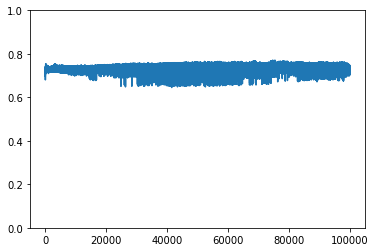

In [284]:
wt_matrix= perceptron.fit(X_train_new,Y_train_binarised,100000,.0075)

In [285]:
y_pred_train = perceptron.predict(X_train_new)
accuracy = accuracy_score(y_pred_train, Y_train_binarised)
print(accuracy)

0.7712609970674487


In [286]:
y_pred_test = perceptron.predict(X_test_new)
y_pred_test = y_pred_test.astype(int)
print(y_pred_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 0 1 1]


In [0]:
y_test = pd.read_csv('sample_submission.csv')

In [288]:
y_test.shape
type(y_test)
y_test.head()
Y_test_final = y_test.drop('PhoneId',axis=1)
Y_test_final.head()
Y_test_final = Y_test_final.values
type(Y_test_final)

numpy.ndarray

In [289]:
accuracy2 = accuracy_score(y_pred_test, Y_test_final)
print(accuracy2)

0.8991596638655462


## Dummy Solution

In [0]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_test_pred})
submission = submission[['PhoneId', 'Class']]
submission.head()

In [0]:
submission.to_csv("submission.csv", index=False)